# Word Generator

This program will use Mantas Lukoševičius' ESN to try to generate new words, from an input text. While the main program is explained in the "Minimal ESN - EN" notebook, we will here focus on the added parts that will help achieving this task.

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from ipywidgets import *
from IPython.display import *

def set_seed(seed=None):
    """Making the seed (for random values) variable if None"""

    if seed is None:
        import time
        seed = int((time.time()*10**6) % 4294967295)
        print(seed)
    try:
        np.random.seed(seed)
        print("Seed used for random values:", seed)
    except:
        print("!!! WARNING !!!: Seed was not set correctly.")
    return seed

class Network(object):

    def __init__(self, trainLen=10000, testLen=2000, initLen=1000) :
        self.initLen = initLen
        self.trainLen = trainLen
        self.testLen = testLen
        self.file = open("shakespeare_input.txt", "r").read()

nw = Network()

The next function analyzes a text (here, the beginning of Sir Arthur Conan Doyle's <i>A Study in Scarlet</i>, containing 3608 symbols), and returns a list containing all the different characters that are present in the text. You can choose between taking case, punctuation and/or numbers into account.

In [4]:
def characters(nw, keep_upper=True, keep_punctuation=True, keep_numbers=True) :

    alphabet = list("abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789 ")
    numbers = list("0123456789")

    if keep_upper == False : nw.file = nw.file.lower()
    nw.input_text = list(nw.file)

    if keep_punctuation == False :
        nw.input_text = [i for i in nw.input_text if i in alphabet]     

    if keep_numbers == False :
        nw.input_text = [i for i in nw.input_text if i not in numbers]

    nw.chars = list(set(nw.input_text))
    print("Existing characters in the text :", nw.chars,"- Number of characters :", len(nw.chars))
    
    return(nw)

nw = characters(nw, True, True, True)

Existing characters in the text : ['\n', 'J', 'o', 'x', 'E', 'a', ']', 'v', 'S', 'A', 'u', 'n', 'I', 'Z', 's', 'z', 'm', 'w', 'W', 'R', 'j', "'", '.', ',', 'H', 'i', '?', 'V', 'O', 'b', 'M', 'P', 'T', '&', ' ', 'k', 'Y', '!', ';', 'F', '[', 'B', '-', 'p', 'h', 'Q', 'X', ':', 'q', 'y', '$', 'c', 'L', 't', 'G', 'l', 'D', 'K', 'C', 'U', 'r', '3', 'g', 'e', 'd', 'N', 'f'] - Number of characters : 67


Finally, we will convert the text values into numerical values, usable by the algorithm. We will consider the input as a vector $u(t)$, where each line matches a different character, according to <b>nw.chars</b>. Since there only can be one character at a time, we will convert the text from nw.input_text into a nw.data vector, where each element will be a character ID according to its position in nw.chars.

In [5]:
nw.data = np.array([nw.chars.index(i) for i in nw.input_text])
print(nw.data)

[39 25 60 ..., 63 22  0]


Now, we can try this on our network. The input $u$ will now be a vector, matching the size of nw.chars. Every time the program "reads" a character, we will give the corresponding u neuron a value of 1. In any other case, this value will be 0. Let's plot the input data.

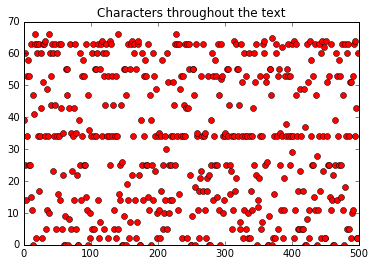

In [6]:
def plot_figure(f) :
    plt.figure(1).clear()
    limit = np.arange(int(f))
    plt.plot(limit,nw.data[0:int(f)], 'ro')
    plt.title('Characters throughout the text')
    
interact(plot_figure, f=FloatSlider(value=500,min=100,max=len(nw.data),step=1,continuous_update=False));

Let's launch the network.

In [7]:
nw.inSize = nw.outSize = len(nw.chars)
nw.resSize = 300
nw.a = 0.3
nw.spectral_radius = 0.25
nw.input_scaling = 1.
nw.reg =  1e-8

nw.mode = 'prediction'

seed = None #42

set_seed(seed)

def binary_data(nw) :
    nw.data_b = np.zeros((len(nw.input_text), len(nw.chars)))
    for i in range(len(nw.data)) :
        nw.data_b[i][nw.data[i]] = 1
    return(nw)    

def initialisation(nw) :
    nw.Win = (np.random.rand(nw.resSize,1+nw.inSize)-0.5) * nw.input_scaling
    nw.W = np.random.rand(nw.resSize,nw.resSize)-0.5 
    nw.X = np.zeros((1+nw.inSize+nw.resSize,nw.trainLen-nw.initLen))
    nw.Ytarget = nw.data_b[nw.initLen+1:nw.trainLen+1].T
    nw.x = np.zeros((nw.resSize,1))  
    return(nw)

def calcul_rayon_spectral(nw):
    print('Calcul du rayon spectral',end=" ")
    rhoW = max(abs(linalg.eig(nw.W)[0]))
    print('effectué.')
    nw.W *= nw.spectral_radius / rhoW
    return(nw)

def train_input(nw) :
    for t in range(nw.trainLen):
        nw.u = nw.data_b[t]
        nw.x = (1-nw.a)*nw.x + nw.a*np.tanh( np.dot(nw.Win, np.concatenate((np.array([1]),nw.u)).reshape(len(nw.chars)+1,1) ) + np.dot( nw.W, nw.x ) )
        if t >= nw.initLen :
            nw.X[:,t-nw.initLen] = np.concatenate((np.array([1]),nw.u,nw.x[:,0])).reshape(len(nw.chars)+nw.resSize+1,1)[:,0]      
    return(nw)

def train_output(nw) :
    nw.X_T = nw.X.T
    if nw.reg is not None:
        nw.Wout = np.dot(np.dot(nw.Ytarget,nw.X_T), linalg.inv(np.dot(nw.X,nw.X_T) + \
            nw.reg*np.eye(1+nw.inSize+nw.resSize) ) )
    else:
        nw.Wout = np.dot(nw.Ytarget, linalg.pinv(nw.X) )   
    return(nw)

def test(nw) :
    nw.Y = np.zeros((nw.outSize,nw.testLen))
    nw.u = nw.data_b[nw.trainLen]
    for t in range(nw.testLen):
        nw.x = (1-nw.a)*nw.x + nw.a*np.tanh( np.dot(nw.Win, np.concatenate((np.array([1]),nw.u)).reshape(len(nw.chars)+1,1)\
                                                   ) + np.dot(nw.W,nw.x ) )
        nw.y = np.dot(nw.Wout, np.concatenate((np.array([1]),nw.u,nw.x[:,0])).reshape(len(nw.chars)+nw.resSize+1,1)[:,0] )
        nw.Y[:,t] = nw.y
        if nw.mode == 'generative':
            # generative mode:
            nw.u = nw.y
        elif nw.mode == 'prediction':
            ## predictive mode:
            nw.u = np.zeros(len(nw.chars))
            nw.u[nw.data[nw.trainLen+t+1]] = 1
        else:
            raise(Exception, "ERROR: 'mode' was not set correctly.")
    return(nw)

def compute_error(nw) :
    errorLen = 500
    mse = sum( np.square( nw.data[nw.trainLen+1:nw.trainLen+errorLen+1] - nw.Y[0,0:errorLen] ) ) / errorLen
    print('MSE = ' + str( mse ))
    return(nw)

def compute_network(nw) :
    nw = binary_data(nw)
    nw = initialisation(nw)
    nw = calcul_rayon_spectral(nw)
    nw = train_input(nw)
    nw = train_output(nw)
    nw = test(nw) 
    nw = compute_error(nw)
    return(nw)

3372219676
Seed used for random values: 3372219676


Now that the program is set, we can launch the program and see the text it generates :

In [8]:
nw = compute_network(nw)

def convert_output(nw) :
    nw.output_text = ""
    for i in range(len(nw.Y.T)) :
        nw.output_text += nw.chars[nw.Y.T[i].argmax()]
    return(nw)

nw = convert_output(nw)
print(nw.output_text)

Calcul du rayon spectral effectué.
MSE = 1508.26175002
ththtl tn ahee Aht tttr torir tnd theeuhoor hetoe t   the    oir ttttr   i nn s an  sns  
MENENIUS:
Whet an tthetde 

MERCIUS:
Ttuaaaaaaou aaua  wou toet s sst
TTER   d    Wha   s aitts zEReiuss

FERCIUS:
Ta    that s ahe sat e  

MER        Whe so a on  ttne the aeruuuueane tndtn at

MERCIUS:
T  n tolt tu t h hhe  thraoet  tetsta tdtth te  hof  sast  ttror  osn  

ecc tu  telt tnl    

Mirst Ctctt     ERuinss tshn thes thet tou tate tlt  l ahu  tst whe heruteueane tndtn at

MERCIUS:
The  aete tntl t    Thtl   and t ss  thet thsl tethtou thutsh

 stt tt tooeou  oen oou nln   Tnd chle t  ndouhesg oee thet t  n  T  hl l tht  ta tn eoae 

MifEUEUS:
Tou tete tirr   hhu   e  

MERCIUS:
Tha  set  thutet  the thr   eeothe cnr  tnd te 

S:r teoerreh  t  l ee eeeeeheeane Tf eohooohre oethetes 
te an tntltn  het t tn teett thrtesd 

First Ctctt     he   thu  e sEReenss An      s r titizzzs th the   hhte 

MifEUEUS:
T  hn tou  tor o  ooouent 